In [1]:
!pwd

/Users/chuhsitseng/flatiron/project/sommelier/notebooks/report


In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import numpy as np
import pandas as pd
import pickle
import re
from sklearn.feature_extraction.text import TfidfVectorizer

In [80]:
# There are totla 129971 records.
wine_data = pd.read_csv("../../data/raw/winemag-data-130k-v2.csv") 

# Data cleaning

In [81]:
wine_data['country'] = wine_data['country'].fillna("Unknown")
wine_data['designation'] = wine_data['designation'].fillna("Unknown")
wine_data['province'] = wine_data['province'].fillna("Unknown")
wine_data['region_1'] = wine_data['region_1'].fillna("Unknown")
wine_data['region_2'] = wine_data['region_2'].fillna("Unknown")
# wine_data['taster_name'] = wine_data['taster_name'].fillna("Unknown")
wine_data['taster_twitter_handle'] = wine_data['taster_twitter_handle'].fillna("Unknown")
wine_data['variety'] = wine_data['variety'].fillna("Unknown")
# wine_data['price'] = wine_data['price'].fillna(0)

#Drop the duplicate descriptions
wine_data = wine_data.drop_duplicates('description') # 10016 duplicates
wine_data.dropna(subset=['price','taster_name'], inplace = True) # 22597 records are unknown taster
wine_data = wine_data[wine_data['price']<=100]  # 3229 records are price>100 

Drop single taster's data less than 4000.

In [94]:
taster_count = wine_data['taster_name'].value_counts()
taster_drop = []
num = 0
for i in range(len(taster_count)):
    if taster_count.values[i] < 4000:
        num +=taster_count.values[i]
        taster_drop.append(taster_count.index[i])
wine_data = wine_data[(~wine_data['taster_name'].isin(taster_drop))]

In [3]:
wine_data.shape #(71088, 14)

(71088, 14)

## Save as pickle

In [107]:
# wine_data.to_pickle('../../data/processed/wine_data.pkl')

In [2]:
# with open('../../data/processed/wine_data.pkl', 'rb') as f:
#     wine_data = pickle.load(f)
# f.close()

There are only about 1148 bottle of wine have more than one taster's review.

In [6]:
wine_data[wine_data['title'].duplicated()].shape

(1148, 14)

# Visualization

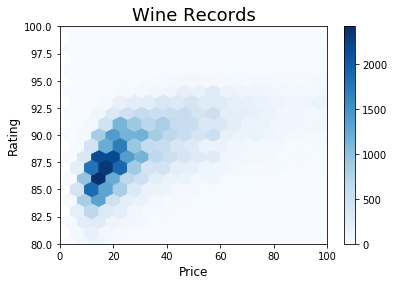

In [112]:
wine_data.plot.hexbin(x='price', y='points',gridsize=18,cmap=plt.cm.Blues, fontsize=10)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.xlim(0,100)
plt.ylim(80,100)
plt.title('Wine Records', fontsize=18)
plt.savefig('../../references/figures/price_points.png', dpi=300)

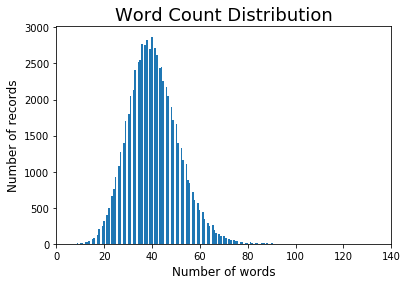

In [113]:
#set x for the histogram and set bins based on max
word_count = wine_data['description'].apply(lambda x: len(str(x).split(" ")))
n_bins = 180
#plot histogram
plt.hist(word_count , bins=n_bins)
plt.xlim(0,140)
plt.xlabel('Number of words', fontsize=12)
plt.ylabel('Number of records', fontsize=12)
plt.title('Word Count Distribution', fontsize=18)
plt.savefig('../../references/figures/word_count.png')

# Create new dataframe

## Copy columns I will use

In [12]:
wine = wine_data[['title','variety','country','taster_name','points','price','winery','description']]

In [14]:
wine = wine.assign(id=(wine['taster_name']).astype('category').cat.codes)
wine = wine.rename(columns={'id': 'taster_id'})
wine = wine.assign(id=(wine['title']).astype('category').cat.codes)
wine = wine.rename(columns={'id': 'wine_id'})

# Analyze description

In [51]:
#loops through descriptions and cleans them
clean_desc = []
for index, row in wine.iterrows():
    desc = row['description'].lower()
    #remove punctuation
    desc = re.sub('[^a-zA-Z]', ' ', desc)
    #remove tags
    desc = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",desc)
    #remove digits and special chars
    desc = re.sub("(\\d|\\W)+"," ",desc)
    clean_desc.append(desc)
    
stop_words = set(stopwords.words("english"))
add_stopwords = ["wine", "drink"]
stop_words = stop_words.union(add_stopwords)

def remove_stopwords(article):
    tokens = nltk.word_tokenize(article)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed 

clean_desc_wo_stopwords = list(map(remove_stopwords, clean_desc))
wine['desc_clean'] = clean_desc_wo_stopwords

## Flavor keywords on Wine Aroma Wheel

In [43]:
# "herbaceous" -> "herb","woody"->"wood"
pri_words = ["fruity", "spicy", "floral", "microbiological", "oxidized", "pungent",
                "chemical","earthy","wood","caramel","nutty","herb","vegetative"]
# "spicy","floral","oxidized","pungent","earthy", "caramel", "nutty"
sec_words = ["citrus","berry","tree","fruit","tropical","dried",
             "yeasty","lactic","cool","hot","sulfur",
             "petroleum","moldy","burned","phenolic","resinous",
             "fresh","canned","cooked"]
ter_words = [#fruity
    "grapefruit", "lemon", "blackberry", "raspberry", "strawberry", "currant",
    "cassis","cherry", "apricot", "peach", "apple", "pineapple", "melon", "banana",
    "jam", "raisin", "prune", "fig", "candied", "concord", "artificial", 
    "methyl", "anthranilate", 
    # spicy
    "licorice", "anise", "pepper", "cloves", 
    # floral
    "geranium", "violet", "rose","orange", "blossom",
    # mocribiological     
    "leesy", "baker", "yoghurt", "sweaty", "sauerkraut", "mousy", "horsey", "champagne"
    # oxidized 
    "oxidized", 
    # pungent
    "menthol", "alcohol", "rubbing",
    # chemical: "sulfur",
    "dioxide", "ethanol", "acetic", "grain","vinegar", "acid", 
    "polish", "ethyl", "wool", "dog", "match", "cabbage", "skunk", 
    "garlic", "gas", "mercaptan", "egg","hydrogen", "rubbery", "diesel", "kerosene",
    "plastic", "tar", "acetate",
    # earthy: "moldy"
    "cork", "mildew", "mushroom", "dusty", 
    # woody: "phenolic"
    "smoky", "burnt", "toast", "coffee", "medicinal", "bandaid", "sawdust", 
    "bacon", "oak", "cedar", "vanilla", 
    # caramel
    "honey", "butterscotch", "diacetyl", "soy", "sauce", "chocolate", "molasses", 
    # nutty
    "walnut", "hazelnut", "almond",
    # herbaceous/vegetative: "pepper"
    "grass", "eucalyptus", 
    "mint", "beans", "asparagus", "olive", "artichoke", "hay", "straw",
    "tea", "tobacco",
    #my add
    "tart", "cranberry", "savory", "mossy", "blueberry"]
flavor_words =  pri_words + sec_words + ter_words

## Stemming

In [57]:
stm = SnowballStemmer("english") 
flavor_words_stem = [stm.stem(word) for word in flavor_words] 

def flavor_words_func(words):
    tokens = nltk.word_tokenize(words)
    stm = SnowballStemmer("english")
    flavor_words_list = [stm.stem(token) for token in tokens if stm.stem(token) in flavor_words_stem  ]
    return flavor_words_list

flavor_words_temp = list(map(flavor_words_func, clean_desc))
wine.loc[:,'flavor_words'] = [['other'] if x == [] else x for x in flavor_words_temp]
wine.loc[:,'flavor_words_str'] = wine.loc[:,'flavor_words'].apply(' '.join)

In [65]:
wine.loc[0:5, ['description', 'desc_clean', 'flavor_words_str']]

,description,desc_clean,flavor_words_str
1,"This is ripe and fruity, a wine that is smooth...","[ripe, fruity, smooth, still, structured, firm...",fruiti berri fruit acid
2,"Tart and snappy, the flavors of lime flesh and...","[tart, snappy, flavors, lime, flesh, rind, dom...",tart pineappl acid
4,"Much like the regular bottling from 2012, this...","[much, like, regular, bottling, comes, across,...",earthi
5,Blackberry and raspberry aromas show a typical...,"[blackberry, raspberry, aromas, show, typical,...",blackberri raspberri herb acid spici fruit fresh


# Content Based Filtering 